# Прогноз температуры стали во время плавки

Цель: построить модель, которая предскажет температуру стали.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns

import shap

import warnings
warnings.simplefilter("ignore")

# 1. Исследовательский анализ данных

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время)

In [2]:
try:
    data_arc_new = pd.read_csv('data_arc_new.csv', parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
    data_bulk_new = pd.read_csv('data_bulk_new.csv')
    data_bulk_time_new = pd.read_csv('data_bulk_time_new.csv')
    data_gas_new = pd.read_csv('data_gas_new.csv')
    data_temp_new = pd.read_csv('data_temp_new.csv', parse_dates=['Время замера'])
    data_wire_new = pd.read_csv('data_wire_new.csv')
    data_wire_time_new = pd.read_csv('data_wire_time_new.csv')
except:
    data_arc_new = pd.read_csv('/datasets/data_arc_new.csv', parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
    data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
    data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv')
    data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp_new = pd.read_csv('/datasets/data_temp_new.csv', parse_dates=['Время замера'])
    data_wire_new = pd.read_csv('/datasets/data_wire_new.csv')
    data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv')

## Данные об электродах

In [3]:
data_arc_new

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


Электроды являются нагревательным элементом. Для каждой партии `'key'` известно начало и конец нагрева, а также активная и реактивная мощность. Всего 3241 партий. 
Проверю пропуски.

In [4]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Пропусков в таблице нет. Посмотрю распределение количества итераций обработки партий.

In [5]:
# Функции визуализации

def histplot(df, title, density=True):
    '''Функция построения гистограммы плотностей'''
    df.hist(bins=int(df.shape[0]/100), density=True, figsize=(10, 6))
    plt.ylabel('Плотность')
    plt.xlabel(df.name)
    plt.title(title)
    
    plt.axvline(x=df.mean(), label=f'mean={df.mean()}', lw=3, c='r')
    plt.axvline(x=df.quantile(0.25), label=f'25%={df.quantile(0.25)}', lw=3, c='g')
    plt.axvline(x=df.quantile(0.75), label=f'75%={df.quantile(0.75)}', lw=3, c='g')
    
    plt.legend()
    return

def hist_box(df, title, density=True):
    '''Функция построения гистограммы плотностей и ящика с усами'''
    plt.figure(figsize=(20, 6))
    plt.subplot(1,2,1)
    histplot(df, title)
    
    plt.subplot(1,2,2)
    sns.boxplot(df)
    plt.title('Ящик с усами')
    return

def barplot(df, title, density=True):
    '''Функция построения столбчатой диаграммы'''
    df.plot(kind='bar', figsize=(20, 4), grid=True)
    plt.ylabel('Количество')
    plt.xlabel(df.name)
    plt.title(title)
    return

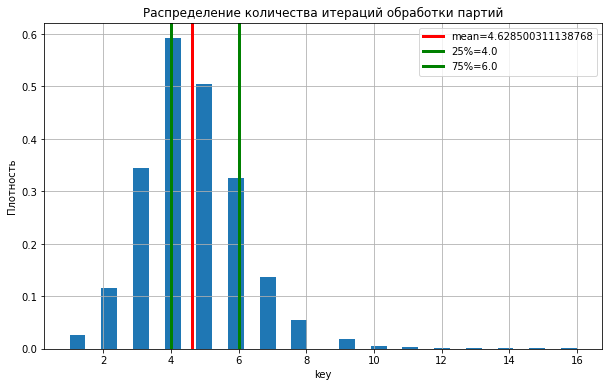

In [6]:
histplot(data_arc_new['key'].value_counts(), 'Распределение количества итераций обработки партий')

In [7]:
data_arc_new['key'].value_counts().describe()

count    3214.000000
mean        4.628500
std         1.608647
min         1.000000
25%         4.000000
50%         4.000000
75%         6.000000
max        16.000000
Name: key, dtype: float64

Из распределения количества итераций обработки партий можно увидеть, что в основном необходимый состав достигается с помощью 4 итераций нагрыва.

Рассчитаю время нагрева каждой итерации, добавив новый столбец '`Время нагрева дугой`'

In [8]:
data_arc_new['Время нагрева дугой'] = (data_arc_new['Конец нагрева дугой'] - data_arc_new['Начало нагрева дугой']).dt.seconds

In [9]:
data_arc_new.head(5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева дугой
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148


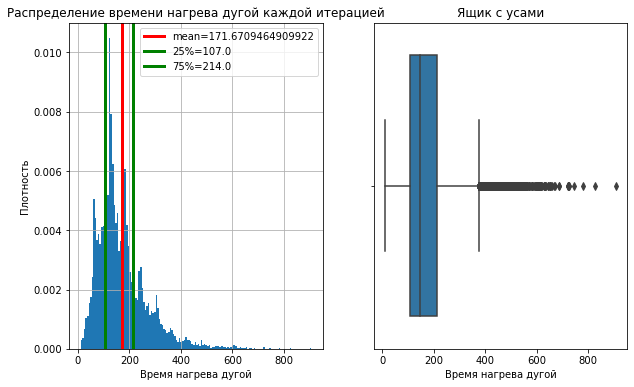

In [10]:
hist_box(data_arc_new['Время нагрева дугой'], 'Распределение времени нагрева дугой каждой итерацией')

В среднем время нагрева в одной итерации составляет 150 с. По ящику с усами наблюдается много выбросов. Посмотрю распределение суммарного нагрева одной партии

In [11]:
data_arc_new.groupby('key').sum()

,Активная мощность,Реактивная мощность,Время нагрева дугой
key,,,
1,3.036730,2.142821,1098
2,2.139408,1.453357,811
3,4.063641,2.937457,655
4,2.706489,2.056992,741
5,2.252950,1.687991,869
...,...,...,...
3237,2.541872,2.025417,909
3238,1.374821,1.038103,546
3239,4.848005,3.541541,1216


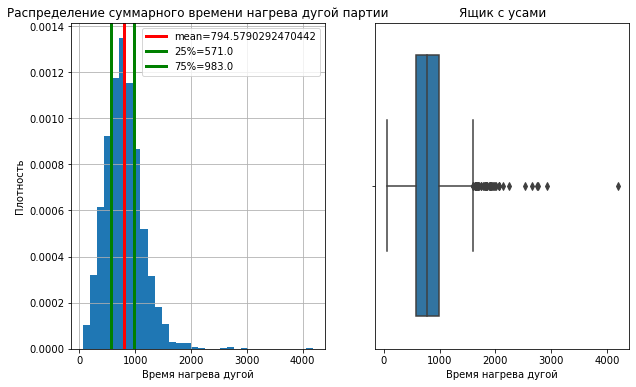

In [12]:
hist_box(data_arc_new.groupby('key').sum()['Время нагрева дугой'], 'Распределение суммарного времени нагрева дугой партии')

Распределение суммарного нагрева стало больше походить на стандартное. Количество выбросов меньше, чем в распределении итераций обработки.

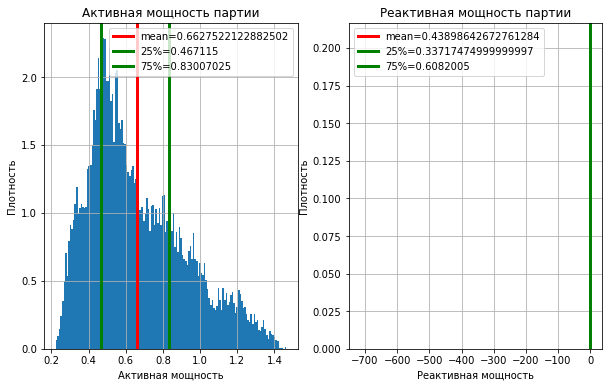

In [13]:
for i, s in enumerate(['Активная мощность', 'Реактивная мощность']):
    plt.subplot(1, 2, i+1)
    histplot(data_arc_new[s], f'{s} партии')

В одной сртоке Реактивная мощность имеет отрицательное значение. Возможно, не корректная запись датчика. Можно предположить, что она на положительна и на три порядка меньше - 0.715. Но лучше перестраховаться и принять выбросом.

In [14]:
data_arc_new[data_arc_new['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева дугой
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924,109


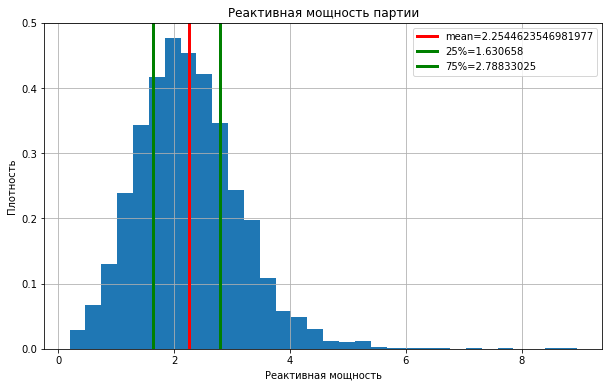

In [15]:
histplot(data_arc_new[data_arc_new['Реактивная мощность'] > 0].groupby('key').sum()['Реактивная мощность'], 
         'Реактивная мощность партии')

**Выводы:**
1. Всего 3241 партий
2. В каждой партии несколько итераций обработки. Среднее кол-во итерации составляет 4 секунды. Среднее время нагрева каждой итерации 150 с
3. Среднее время нагрева всей партии 795 с. Средняя Активная мощность партии - 0.66 каких-то единиц.
4. Имеется строка с отрицательной Реактивной мощностью.
5. Средняя Реактивная мощность без учета отрицательного значения 2.25 каких-то единиц.
6. В таблице приведены данные не по всем партиям `key`.

## Данные о подаче сыпучих материалов (объём)

In [16]:
data_bulk_new

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [17]:
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [18]:
data_bulk_new.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


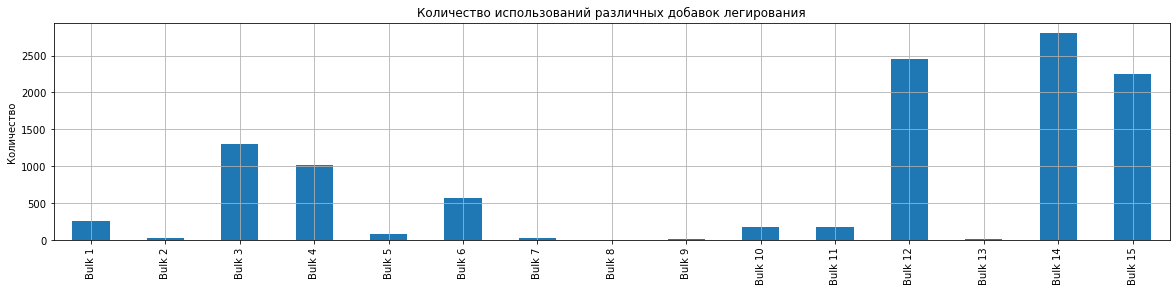

In [19]:
barplot(data_bulk_new.count()[1:], 'Количество использований различных добавок легирования')

**Вывод:**
1. В таблице приведены добавки для всей партии, а не итераций обработки. То есть не ясно в какой момент времени она была добавлена (об этом, вероятно, информация есть в `data_bulk_time_new`)
2. Можно соеденить с `data_arc_new`, ссумируя общее времи нагрева и мощности последней
3. Чаще других используется добавка №14
4. Есть партии, в которые не добавляли добавки

## Данные о подаче сыпучих материалов (время)

In [20]:
data_bulk_time_new

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-09-06 11:54:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 11:49:45,NaN,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaN,NaN,2019-09-06 12:26:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 12:18:35,NaN,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:06:00,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:01:44,NaN,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:24:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:07:29,2019-09-06 16:01:34


In [21]:
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


**Вывод:**
Действительно, таблица совпадает с `data_bulk_new`, только вместо объемов указано время добавления. В теории, по времени добавления лигирующего материала можно соотнести с итерацией нагрева в `data_arc_new`

## Данные о продувке сплава газом

In [22]:
data_gas_new

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


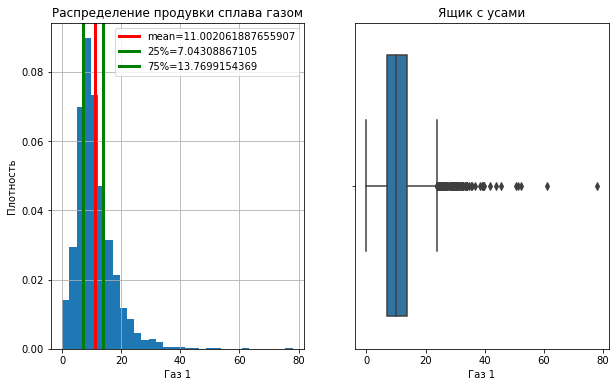

In [23]:
hist_box(data_gas_new['Газ 1'], 'Распределение продувки сплава газом')

**Выводы:**
1. В таблице приведены данные не по всем партиям `key`
2. Делать выводы по данной таблице преждевременно из-за непонятности данных. Степень важности данных определить не удалось


## Результаты измерения температуры

In [24]:
data_temp_new

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [25]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [26]:
data_temp_new.groupby('key').mean()

,Температура
key,
1,1602.166667
2,1590.600000
3,1598.166667
4,1616.800000
5,1589.000000
...,...
3237,1569.000000
3238,1584.000000
3239,1598.000000


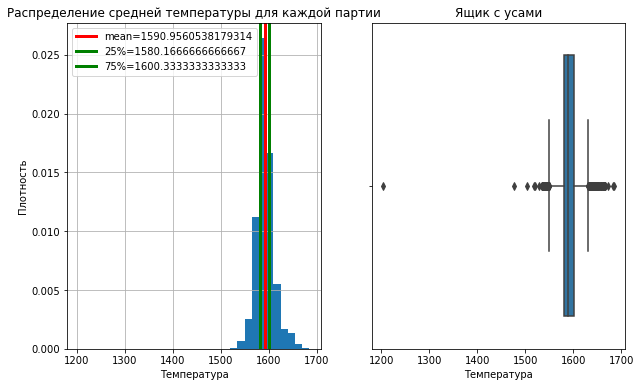

In [27]:
hist_box(data_temp_new.groupby('key').mean()['Температура'], 'Распределение средней температуры для каждой партии')

**Выводы:**
1. Целевая переменная располагается в данной таблице - последняя температура итерации.
2. Для каждой итерации обработки можно сопоставить температуру по времени замера.
3. Имеются пропуски замеров температур.
4. Количество данных по итерациям меньше, чем в данных об электродах.
5. С каждой итерацией изменение температуры не монотонное
6. Количество партий не соответствует в данных об электродах.
7. Распределение средней температуры обработки каждой партии подобно стандартному распределению. Имеются выбросы. Выбросы могут говорить о нештатных ситуациях во время обработки.

## Данные о проволочных материалах (объём)

In [28]:
data_wire_new

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [30]:
data_wire_new.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


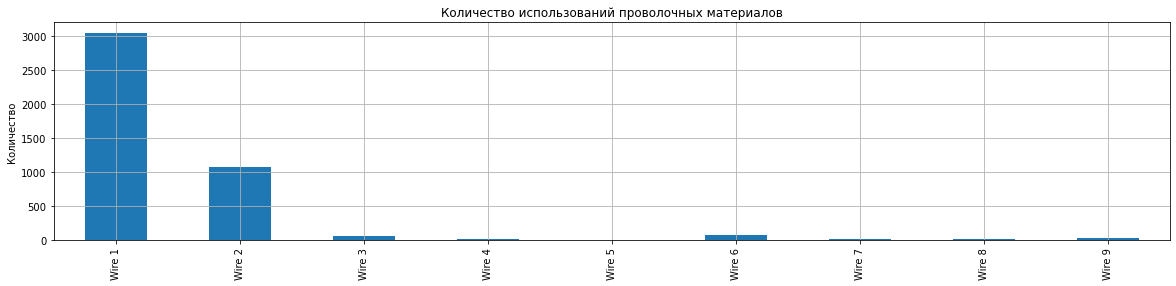

In [31]:
barplot(data_wire_new.count()[1:], 'Количество использований проволочных материалов')

**Вывод:**
1. В таблице приведены добавки для всей партии, а не итераций обработки
2. Можно соеденить с `data_arc_new`, ссумируя общее времи нагрева и мощности последней
3. Чаще других используется добавка 1
4. Есть партии, в которые не добавляли добавки

## Данные о проволочных материалах (время)

In [32]:
data_wire_time_new

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-09-06 11:33:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-09-06 12:18:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-06 14:36:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-06 15:33:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


**Вывод:**
Таблица совпадает с `data_wire_new`, только вместо объемов указано время добавления. В теории, по времени добавления проволочных материалов можно соотнести с итерацией нагрева в `data_arc_new`

# Общий вывод:
1. Всего 3241 партий
2. В каждой партии несколько итераций обработки. По времени нагрева каждой итераци обработки можно соотнести количество сыпучих и проволочных материалов, а также температуру в ковше. 
3. Имеется строка с отрицательной Реактивной мощностью.
4. Во всех таблицах приведены данные не по всем партиям `key`. 
5. Имеются пропуски замеров температур.
6. Распределение средней температуры обработки каждой партии подобно стандартному распределению. Имеются выбросы. Выбросы могут говорить о нештатных ситуациях во время обработки.

# План работы

Предсказание температуры стали поможет уменьшить время нагрева, и, следовательно, электроэнергии. Целевой является конечная температура каждой итерации обработки.Поэтому датасеты со сременем добавления сыпучих материалов и проволок являются лишними благодаря тому, что отпала необходимость сопоставлять их добавляение с итерациями.

1. Удаление партии с некоректными значениями температуры сплава и реактивной мощности. 
2. Для каждой партии определяются первая и последняя измеренные температуры стали. Удаляляюся полностью вся партия в случае некоректности данных одной итерации. 
3. Создаются новые признаки.
4. Объединение таблицы `data_temp_min_max`, `data_arc_total`, `data_wire_new`, `data_bulk_new` и `data_gas_new`, соотнося по времени нагрева каждой итераци обработки количество сыпучих и проволочных материалов, а также температуру в ковше.
5. Удаление партии с пропущенными значениями температуры в ковше, количеством сыпучих и проволочных материалов. Заполняются пропуски нулями в итерациях обработки.
6. Удаление столбцов с информацией о времени и номере партии `'key'`. 
7. Разделение датасет на обучающую и тестовую выборки. Выделяются признаки и целевая переменная - конечная температура.
8. Масштабирование признаков
9. Обучение несколько моделей, решая задачу регрессии с ипользованием кросс-валидации. По оценке кросс-валидации (заказчику важна метрика MAE) выберем лучшую модель и построим прогноз.
11. Проверка модель на простейшей dummy модели
12. Оценка экономии электроэнергии.

# Предобработка данных

In [34]:
data_temp_new

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


Удалю из `data_temp_new` партии с температорой сплава < 1400 - данное значение соответствует температуре плавления стали.

In [35]:
# список партий с температурой 
list(data_temp_new[data_temp_new['Температура'] < 1400]['key'])

[867, 1214, 1619, 2052, 2561]

In [36]:
# количество партий без температур 
data_temp_new[data_temp_new['Температура'].isna()]['key'].nunique()

739

In [37]:
data_temp_new = data_temp_new.loc[~data_temp_new['key'].isin(list(data_temp_new[data_temp_new['Температура'] < 1400]['key']))]
data_temp_new = data_temp_new.loc[~data_temp_new['key'].isin(list(data_temp_new[data_temp_new['Температура'].isna()]['key'].unique()))]
data_temp_new

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
13921,2499,2019-08-10 13:33:21,1569.0
13922,2499,2019-08-10 13:41:34,1604.0
13923,2499,2019-08-10 13:46:28,1593.0
13924,2499,2019-08-10 13:54:56,1588.0


Для каждой партии определию первую и последнюю измеренные температуры стали, выделив их в отдельный датасет `data_temp_min_max`.

In [38]:
def min_max(df):
    '''Функция извлечения первой и последней температуры каждой итерации обработки'''
    df['Первая температура'] = df.loc[df['Время замера'] == df['Время замера'].min(), 'Температура']
    df['Целевая температура'] = df.loc[df['Время замера'] == df['Время замера'].max(), 'Температура']
    return df

In [39]:
data_temp_min_max = data_temp_new.groupby('key').apply(min_max)
data_temp_min_max = data_temp_min_max.groupby('key').sum()[['Первая температура', 'Целевая температура']].reset_index()
data_temp_min_max

,key,Первая температура,Целевая температура
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2468,2495,1570.0,1591.0
2469,2496,1554.0,1591.0
2470,2497,1571.0,1589.0
2471,2498,1591.0,1594.0


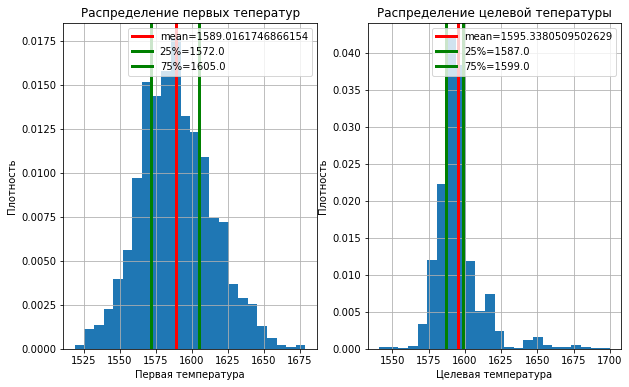

In [40]:
plt.figure()
plt.subplot(1,2,1)
histplot(data_temp_min_max['Первая температура'], 'Распределение первых теператур')
plt.subplot(1,2,2)
histplot(data_temp_min_max['Целевая температура'], 'Распределение целевой тепературы')

Для того, чтобы нагреть сплав, необходимо подвести теплоту, которая равна произведению активной мощности на время нагрева. Выделю ее в отдельный признак. Также создам признак полной мощности.
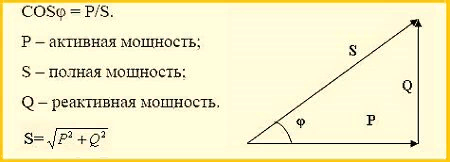

In [41]:
data_arc_total = data_arc_new.groupby('key').sum()[data_arc_new.groupby('key').sum()['Реактивная мощность'] > 0].reset_index()
data_arc_total['Теплота'] = data_arc_total['Активная мощность'] * data_arc_total['Время нагрева дугой']
data_arc_total['Полная мощность'] = np.sqrt(data_arc_total['Активная мощность']**2 + data_arc_total['Реактивная мощность']**2)
data_arc_total

,key,Активная мощность,Реактивная мощность,Время нагрева дугой,Теплота,Полная мощность
0,1,3.036730,2.142821,1098,3334.329540,3.716640
1,2,2.139408,1.453357,811,1735.059888,2.586371
2,3,4.063641,2.937457,655,2661.684855,5.014163
3,4,2.706489,2.056992,741,2005.508349,3.399456
4,5,2.252950,1.687991,869,1957.813550,2.815155
...,...,...,...,...,...,...
3208,3237,2.541872,2.025417,909,2310.561648,3.250143
3209,3238,1.374821,1.038103,546,750.652266,1.722728
3210,3239,4.848005,3.541541,1216,5895.174080,6.003804
3211,3240,3.317679,2.373552,839,2783.532681,4.079307


Объединим таблицы `data_temp_min_max`, `data_arc_total`, `data_wire_new`, `data_bulk_new` и `data_gas_new`, оставив пересекающие партии

In [42]:
data_wire_new.fillna(0, inplace=True)
data_bulk_new.fillna(0, inplace=True)

wire = data_wire_new.groupby('key').sum().reset_index()
bulk = data_bulk_new.groupby('key').sum().reset_index()
wire_bulk = wire.merge(bulk, on='key', how='inner')

total_df = data_temp_min_max.merge(data_arc_total, on='key', how='inner')
total_df = total_df.merge(wire_bulk, on='key', how='inner')
total_df = total_df.merge(data_gas_new, on='key', how='inner')
total_df.drop('key', inplace=True, axis=1)
total_df

,Первая температура,Целевая температура,Активная мощность,Реактивная мощность,Время нагрева дугой,Теплота,Полная мощность,Wire 1,Wire 2,Wire 3,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1
0,1571.0,1613.0,3.036730,2.142821,1098,3334.329540,3.716640,60.059998,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,1581.0,1602.0,2.139408,1.453357,811,1735.059888,2.586371,96.052315,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,1596.0,1599.0,4.063641,2.937457,655,2661.684855,5.014163,91.160157,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,1601.0,1625.0,2.706489,2.056992,741,2005.508349,3.399456,89.063515,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,1576.0,1602.0,2.252950,1.687991,869,1957.813550,2.815155,89.238236,9.11456,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,1570.0,1591.0,3.168133,2.210936,723,2290.560159,3.863328,89.150879,0.00000,0.0,...,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735
2320,1554.0,1591.0,4.174918,2.872031,940,3924.422920,5.067396,114.179527,0.00000,0.0,...,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616
2321,1571.0,1589.0,3.605239,2.452092,569,2051.380991,4.360104,94.086723,9.04800,0.0,...,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699
2322,1591.0,1594.0,3.202310,2.239820,750,2401.732500,3.907887,118.110717,0.00000,0.0,...,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657


Таким образом из 3241 партии после объединения таблиц, чистки и удаления пропусков для обучения осталось 2324 партии. Посмотрю линейную корреляцию признаков.

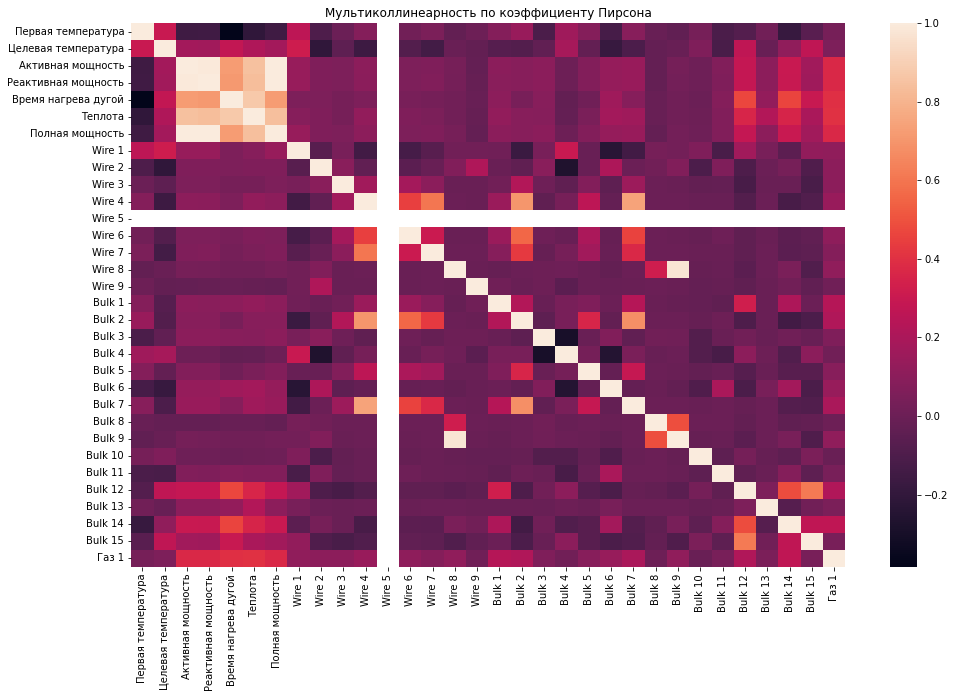

In [43]:
plt.figure(figsize=(16, 10))
sns.heatmap(total_df.corr())
plt.title('Мультиколлинеарность по коэффициенту Пирсона');

Активная и реактивная мощности имеют сильную корреляци. Каждая из них имеет сильную корреляцию с полной мощностью, что ожидаемо. Удалю данные мощности, оставив только полную. Удалю и время нагрева дугой, так как она является составляющей теплоты. Также удалю `'Wire 5'`, посколько он полностью равен нулю.


P.S.: Забегая вперед можно сказать, что у лучшей модели признаки `'Wire 9'`, `'Wire 8'`, `'Wire 7'`, `'Bulk 7'`, `'Bulk 8'`, `'Wire 4'`, `'Bulk 13'`, `'Wire 3'`, `'Bulk 2'` имели нулевой вес. Удалю и их.

In [44]:
total_df.drop(['Активная мощность', 'Реактивная мощность', 'Wire 5', 'Bulk 9'], inplace=True, axis=1)

total_df.drop(['Wire 9', 'Wire 8', 'Wire 7', 'Bulk 7', 'Bulk 8', 'Wire 4', 'Bulk 13', 'Wire 3', 'Bulk 2'], inplace=True, axis=1)

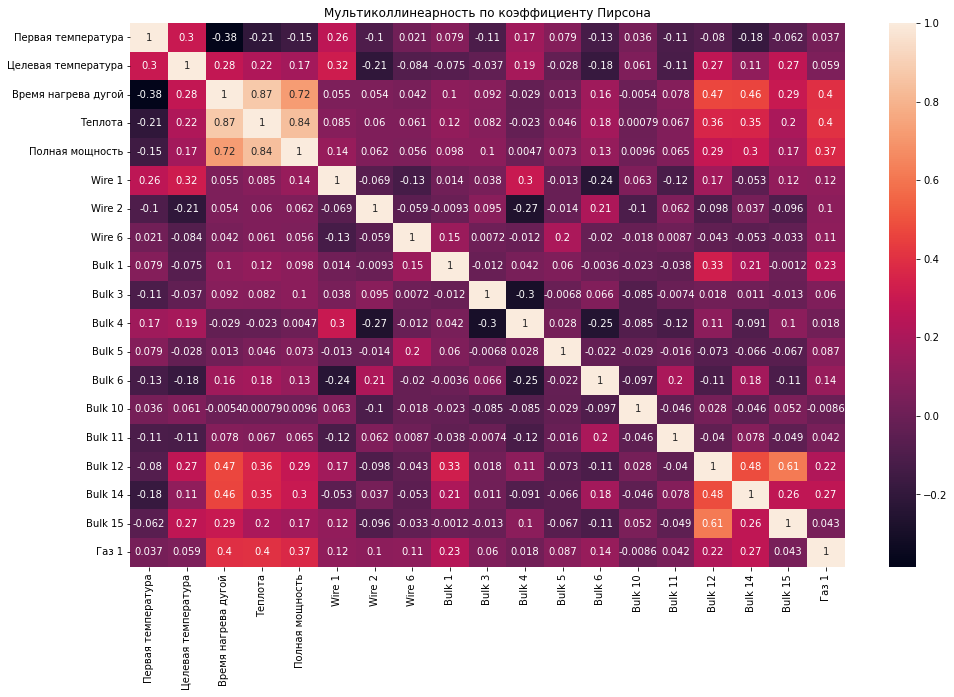

In [45]:
plt.figure(figsize=(16, 10))
sns.heatmap(total_df.corr(), annot=True)
plt.title('Мультиколлинеарность по коэффициенту Пирсона');

Признаков к коэффициентом корреляции > 0.9 нет. Взглянем на рапределения, убедившись, что данные готовы к обучению

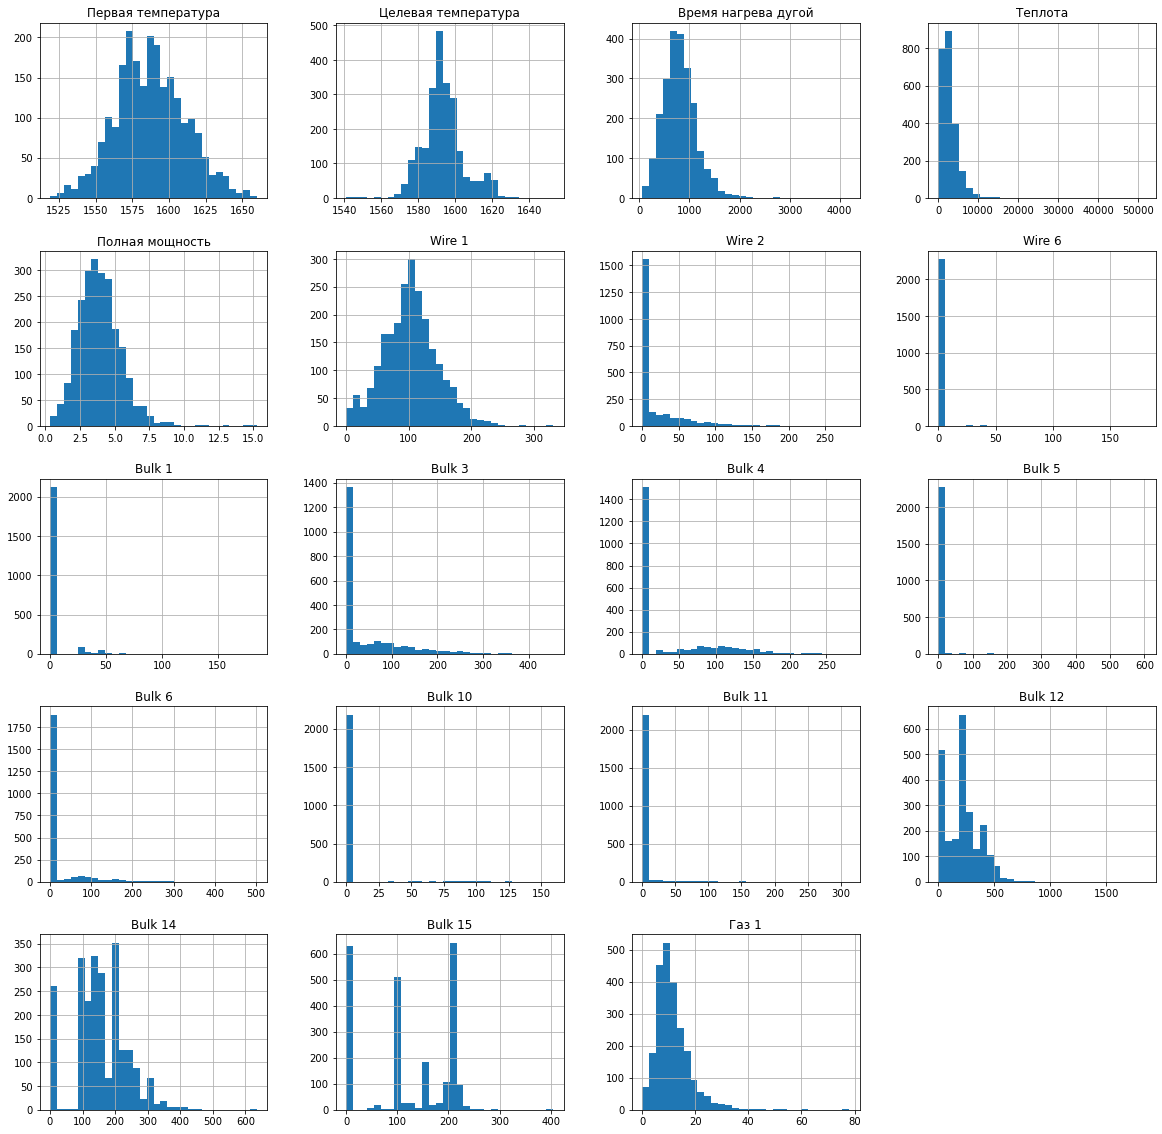

In [46]:
total_df.hist(figsize=(20,20), bins=30);

## Построение моделей

Разобъю итоговый набор данных на выборки, оставив для теста 25% данных.

In [47]:
RANDOM_STATE = 280823

features = total_df.drop('Целевая температура', axis=1)
target = total_df['Целевая температура']

X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size=0.25, 
                                                    random_state=RANDOM_STATE)

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (1743, 18)
X_test: (581, 18)
y_train: (1743,)
y_test: (581,)


In [48]:
# F-тест
freg = f_regression(X_train, y_train)
freg = pd.Series(freg[0], index=X_train.columns).sort_values(ascending=False)
freg.head(15)

Время нагрева дугой    202.597157
Первая температура     190.941279
Wire 1                 188.620351
Теплота                160.873453
Bulk 12                147.746655
Bulk 15                147.578521
Wire 2                  95.019972
Полная мощность         90.106236
Bulk 4                  69.065908
Bulk 6                  62.288703
Bulk 14                 20.722106
Bulk 11                 18.701824
Bulk 10                  9.670236
Газ 1                    8.995900
Bulk 1                   5.636579
dtype: float64

In [49]:
# Тест на взаимную ифнормацию
mir = mutual_info_regression(X_train, y_train)
mir = pd.Series(mir, index=X_train.columns).sort_values(ascending=False)
mir.head(15)

Первая температура     0.091690
Wire 1                 0.084295
Полная мощность        0.076261
Bulk 4                 0.072095
Теплота                0.071542
Bulk 14                0.061862
Bulk 12                0.060792
Время нагрева дугой    0.059270
Bulk 6                 0.059045
Bulk 15                0.049652
Wire 2                 0.031498
Газ 1                  0.028573
Bulk 3                 0.020982
Bulk 10                0.011152
Bulk 11                0.008842
dtype: float64

В этой работе обучу три модели:
- LinearRegression,
- CatBoostRegressor,
- LGBMRegressor.

Для LinearRegression и LGBMRegressor применю масштабирование данных. CatBoostRegressor не нуждается в этом, так как имеет встроеное масштабирование.

Оценка модели будет проводиться с применением кросс-валидации по метрики MAE. Для моделей градиентного бустинга кросс-валидация будет осуществляться с помощью RandomizedSearchCV.

Использую гиперпараметры моделей градиентного бустинга:
- количество деревье
- грубина деревьев
- скорость обучения

Оберну вышеперечисленное в Pipeline с помощью функции `pipe_model`

In [50]:
def pipe_model(X_tr, y_tr, clf, param_grid, scale, linear):
    if scale == True:
        pipe = Pipeline([('scaler', StandardScaler()),
                         ('regression', clf)])
    else:
        pipe = Pipeline([('regression', clf)])
        
    if linear == True:
        scores = cross_val_score(pipe, X_tr, y_tr, cv=5, scoring='neg_mean_absolute_error')
        print('MAE кросс-валидации:', -scores.mean())
        model = pipe.fit(X_tr, y_tr)
    else:
        grid = RandomizedSearchCV(pipe, param_grid, n_jobs=-1, cv=5, 
                              scoring='neg_mean_absolute_error',
                              random_state=RANDOM_STATE)
        model = grid.fit(X_tr, y_tr)
        print('MAE кросс-валидации:', -grid.best_score_)
    return model

In [51]:
%%time
param_grid_cat={'regression__iterations': range(4, 301, 4),
                'regression__depth': range(2, 21),
                'regression__learning_rate': np.arange(0, 1.2, 0.1)}

param_grid_lgmb={'regression__n_estimators': range(4, 301, 4),
                 'regression__max_depth': range(2, 21),
                 'regression__learning_rate': np.arange(0, 1.1, 0.1)}



print('-----------LinearRegression-----------')
lin = pipe_model(X_train, y_train,
                LinearRegression(),
                param_grid=None, 
                scale=True,
                linear=True)

print('-----------Catboost-----------')
cat = pipe_model(X_train, y_train,
                CatBoostRegressor(random_state=RANDOM_STATE,  verbose=False, loss_function='MAE', eval_metric='MAE'),
                param_grid_cat, 
                scale=False,
                linear=False)

print('-----------LightGBM-----------')
lgbm = pipe_model(X_train, y_train,
                 LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, objective='mae', metric='mae'),
                 param_grid_lgmb, 
                 scale=True,
                 linear=False)

-----------LinearRegression-----------
MAE кросс-валидации: 6.172244622134357
-----------Catboost-----------
MAE кросс-валидации: 6.051470127812055
-----------LightGBM-----------
MAE кросс-валидации: 6.011273603881902
Wall time: 8min 33s


In [52]:
print('-----------Лучшая модель-----------')
lgbm.best_estimator_

-----------Лучшая модель-----------


Pipeline(steps=[('scaler', StandardScaler()),
                ('regression',
                 LGBMRegressor(max_depth=7, metric='mae', n_estimators=88,
                               objective='mae', random_state=280823))])

Лучшей моделью из оценки кросс-валидации оказалась LGBMRegressor. К тому же, она заметно быстрее CatBoostRegressor.

Определю оценку прогноза

In [53]:
pred = lgbm.predict(X_test)
print('МАЕ предсказания:', mean_absolute_error(y_test, pred))

МАЕ предсказания: 6.6801862422577125


Проверю предсказания на адекватность с помощью простейшей константной модели `DummyRegressor`

In [54]:
print('-----------DummyRegressor-----------')
dummy = pipe_model(X_train, y_train,
                DummyRegressor(),
                param_grid=None, 
                scale=True,
                linear=True)
pred_dummy = dummy.predict(X_test)
print('МАЕ предсказания констанстной модели:', mean_absolute_error(y_test, pred_dummy))

-----------DummyRegressor-----------
MAE кросс-валидации: 8.040992973247686
МАЕ предсказания констанстной модели: 8.258009663438608


Константная простейшая модель предсказывает конечную температуру сплава со значительно большей ошибкой. Это говорит об адекватности наших моделей и их оценке. В противном случае это бы означало, что любая рандомная модель могла предсказать целевую переменную лучше нашей модели.

## Анализ важности признаков

In [55]:
features_weights = lgbm.best_estimator_._final_estimator.feature_importances_

weights = pd.DataFrame(features_weights, X_test.columns, columns = ['Веса']).sort_values(by='Веса', ascending=False)
weights.T

,Время нагрева дугой,Первая температура,Газ 1,Bulk 14,Wire 1,Полная мощность,Теплота,Bulk 12,Bulk 15,Wire 2,Bulk 3,Bulk 4,Bulk 6,Bulk 1,Bulk 11,Bulk 10,Wire 6,Bulk 5
Веса,309,242,233,184,176,175,119,109,107,102,90,69,58,42,17,12,3,1


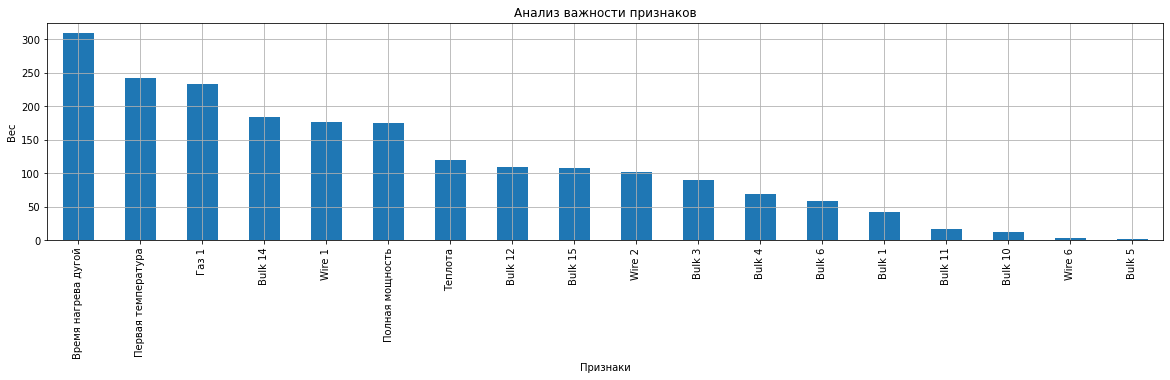

In [56]:
weights['Веса'].plot(kind='bar', figsize=(20, 4), grid=True)
plt.ylabel('Вес')
plt.xlabel('Признаки')
plt.title('Анализ важности признаков');

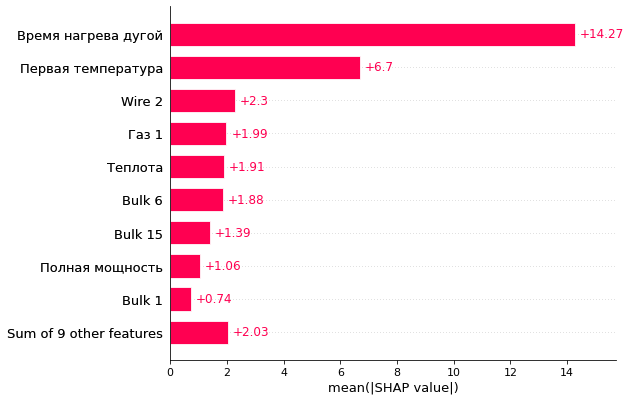

In [57]:
explainer = shap.Explainer(lgbm.best_estimator_._final_estimator)
shap_values = explainer(X_train)


shap.plots.bar(shap_values)

Согласно лучшей модели LGBMRegression наиболее важным признаками являются:
- Время нагрева сплава
- Температура сплава до обработки
- Объем газов при продувки
- Объем сыпучего материала Bulk 14
- Объем проволочного материала Wire 1
- Полная мощность.

Примечательно, что время нагрева важнее температуры сплава до обработки.

Для предприятия важно контролиролировать диапазон нагрева сплава, ведь чем меньше недогрева и перегрева, а также продувки (которая, очевидно, охлаждает), тем ниже затратов на электроэнергию. Попробую сколько бы получилось сэкономить, применив в производстве обученную модель. 

Если в тренировочном датасете посчитать разницу целевой и начальной температур, а потом поделить полную мощность на данную разницу - получим мощность, необходимая для нагрева на 1 градус. Найду среднюю мощность, необходимую для нагрева на 1 градус. По распределению целевой температуры найду медианную - будем считать, что медианная температура и есть та, вокруг которой необходимо контролировать диапазон. Вычту из предсказанных температур медианную и умножу на среднюю мощность, необходимая для нагрева на 1 градус - получу перерасход мощности. 

Буду считать перерасходом только перегрев. Недогрев до необходимой температуры не учту, так как все равно придется потратить энергию на догрев.

In [58]:
temp_range = y_train - X_train['Первая температура']
ind = temp_range[temp_range > 0].index
mean_temp_range = temp_range[temp_range > 0].mean()
print('Средняя температура перегрева:', mean_temp_range)

Средняя температура перегрева: 20.268500948766604


In [59]:
relative_power = (X_train.loc[ind, 'Полная мощность'] / temp_range[ind]).mean()
print('Средняя можность на нагрев на 1 градус:', relative_power)

Средняя можность на нагрев на 1 градус: 0.4693691005524956


In [60]:
delta = X_test['Первая температура'] - y_test.median()
overheat = (delta[delta > 0] * relative_power).sum()
print('Суммарный перерасход мощности на перегрев:', overheat)

Суммарный перерасход мощности на перегрев: 1891.0881061260047


In [61]:
ec = (X_test['Полная мощность'].sum() - overheat) * 100 / X_test['Полная мощность'].sum()
print(f'То есть можно cэкономить {ec} %')

То есть можно cэкономить 17.119609776691366 %


## Отчет

Ключевым шагом в решении задачи стоит выделить определение целевой переменной (конечной температуры). В зависимости от цели существенно изменяется предобработка данных. Также существенным является удаление/не удаление выбрасов. В данной случае было принято их не удалять, учтя в модели несовершенность производственного процесса в широком диапазоне полученных данных. Применение масштабирования признаков в пайлайне позволило исключить утечку данных и избавиться от применения fit и transform на выборках. 

Итоговый набор признаков, используемый в лучшей модели:
- Первая измеренная температура партии (до обработки)
- Время нагрева партии дугой в секундах 
- Теплота = Актиная мощность * нагрева партии дугой
- Полная мощность - евклидово расстояние между векторами активной и реактивной мощности, 
- Объем сыпучих материалов (Wire 1, Wire 2, Wire 6), 
- Объем проволочных материалов (Bulk 1, Bulk 3, Bulk 4, Bulk 5, Bulk 6, Bulk 10, Bulk 11, Bulk 12, Bulk 14, Bulk 15), 
- Объем газа продувки (Газ 1)
Удалялись партии с температурой менее 1400 градусов - температура плавления стали. Также удалялись партии с отрицательной реактивной мощностью. Признаки Активная, Реактивная мощность и Wire 5 из-за высокой линейной корреляции были исключены. Признаки Wire 9, Wire 8, Wire 7, Bulk 7, Bulk 8, Wire 4, Bulk 13, Wire 3 и Bulk 2 не влияли на результат модели, поэтому также были исключены.

В задачи использовались три модели:
- LinearRegression,
- CatBoostRegressor,
- LGBMRegressor.

Для LinearRegression и LGBMRegressor применили масштабирование данных. CatBoostRegressor не нуждается в этом, так как имеет встроеное масштабирование.

Оценка модели проводилась с применением кросс-валидации по метрики MAE. Для моделей градиентного бустинга кросс-валидация осуществлялась с помощью RandomizedSearchCV.

Используемые гиперпараметры моделей градиентного бустинга:
- количество деревьев
- глубина деревьев
- скорость обучения

Лучшей моделью оказалась LGBMRegressor с MAE кросс-валидации 6.011. Лучшая модель имела следующие гиперпараметры:
- максимальная глубина деревьев - 7, 
- функция потерь - mae,
- количество деревьев - 88,
- random_state - 280823.

Оценка МАЕ прогноза лучшей модели составила 6.68, что соответствует требованию заказчика. 

Модель была впроверена на корректность с помощью простейшей Dummу модели. 

Согласно лучшей модели LGBMRegression наиболее важным признаками являются:
- Время нагрева сплава
- Температура сплава до обработки
- Объем газов при продувки
- Объем сыпучего материала Bulk 14
- Объем проволочного материала Wire 1
- Полная мощность.

Улучшить модель можно попытаться с помощью химического состава сплава на каждой итерации, а также информации о рекомендуемой конечной температуре сплава. В таком случае можно будет предсказывать температуру на каждой итерации обработки, корректируя нагрев, исключив перегрев, что сэкономит электроэнергию.